# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_df = pd.read_csv("../input/digit-recognizer/train.csv")
test_df = pd.read_csv("../input/digit-recognizer/test.csv")

In [3]:
train_df.shape

(42000, 785)

In [4]:
test_df.shape

(28000, 784)

In [5]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y_train = train_df['label']
X_train = train_df.drop(columns=['label'])

In [7]:
y_train.head(10)

0    1
1    0
2    1
3    4
4    0
5    0
6    7
7    3
8    5
9    3
Name: label, dtype: int64

In [8]:
X_train.head(10)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
del train_df

<AxesSubplot: xlabel='label', ylabel='count'>

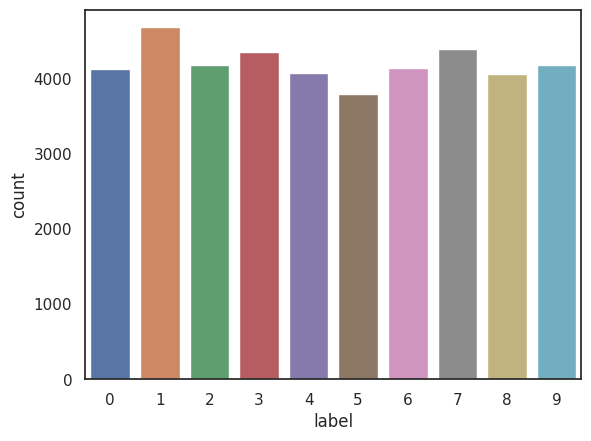

In [10]:
sns.countplot(x=y_train)

In [11]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [12]:
y_train.isnull().sum()

0

In [13]:
X_train.isnull().any().sum()

0

# Preprocessing

In [14]:
X_train = X_train/255.0
test_df = test_df/255.0

In [15]:
X_train.shape

(42000, 784)

In [16]:
X_train = X_train.values.reshape(-1,28,28,1)
X_train.shape

(42000, 28, 28, 1)

In [17]:
test_df = test_df.values.reshape(-1,28,28,1)
test_df.shape

(28000, 28, 28, 1)

In [18]:
y_train = to_categorical(y_train,num_classes=10)

In [19]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

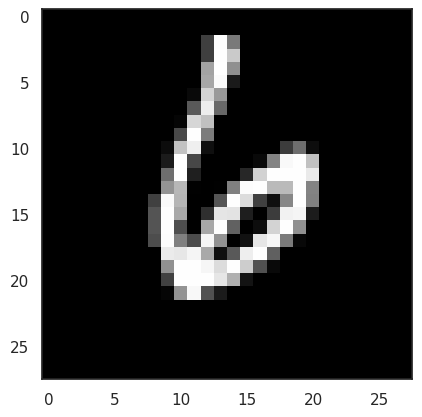

In [21]:
plt.imshow(X_train[0][:,:,],cmap='gray')

# CNN Model

In [22]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [24]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [25]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [26]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [27]:
epochs = 5 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 64

# Data Augmentation

In [28]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [29]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                                  verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/5


/tmp/ipykernel_23/857378775.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
2023-05-17 17:50:34.373694: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


525/525 [==============================] - 19s 23ms/step - loss: 0.4118 - accuracy: 0.8672 - val_loss: 0.0611 - val_accuracy: 0.9824 - lr: 0.0010
Epoch 2/5
525/525 [==============================] - 13s 24ms/step - loss: 0.1327 - accuracy: 0.9617 - val_loss: 0.0464 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 3/5
525/525 [==============================] - 12s 23ms/step - loss: 0.0991 - accuracy: 0.9697 - val_loss: 0.0297 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 4/5
525/525 [==============================] - 12s 23ms/step - loss: 0.0875 - accuracy: 0.9750 - val_loss: 0.0372 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 5/5
525/525 [==============================] - 13s 24ms/step - loss: 0.0791 - accuracy: 0.9767 - val_loss: 0.0244 - val_accuracy: 0.9908 - lr: 0.0010


In [30]:
model.evaluate(X_val,y_val)

263/263 [==============================] - 1s 3ms/step - loss: 0.0244 - accuracy: 0.9908


[0.02440536953508854, 0.9908333420753479]

# Evaluation

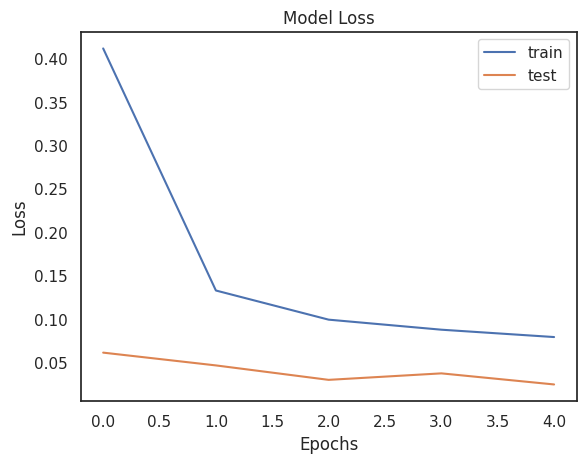

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

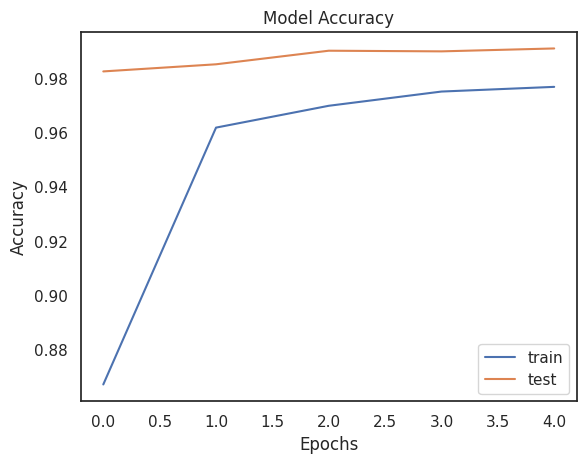

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [33]:
train_label_np = np.argmax(y_train,axis=1)
train_label_np
test_label_np = np.argmax(y_val,axis=1)
test_label_np

array([8, 1, 9, ..., 3, 0, 9])

In [34]:
def calc_pred (model, data):
    prediction = model.predict(data)
    class_predicted= np.argmax(prediction,axis=1)
    return class_predicted

In [35]:
predicted_train = calc_pred(model,X_train)
predicted_test = calc_pred(model,X_val)
predicted_test

263/263 [==============================] - 1s 2ms/step


array([8, 1, 9, ..., 3, 0, 9])

<AxesSubplot: >

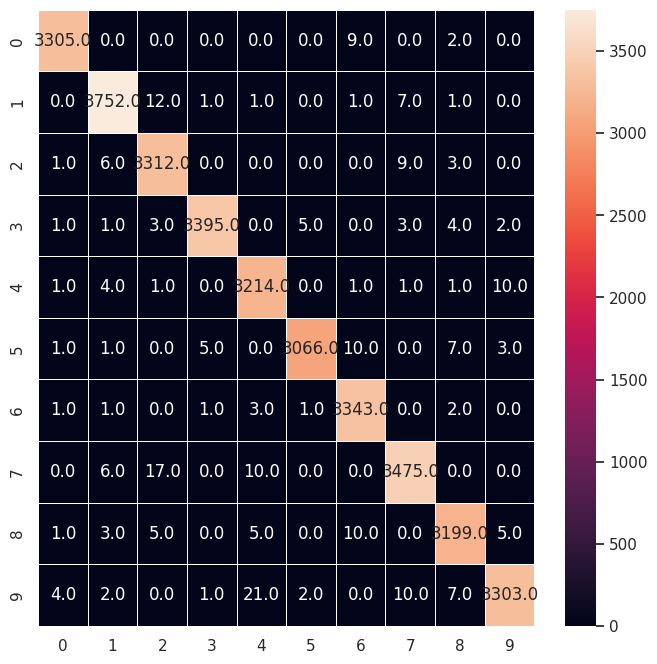

In [36]:
cm_train= confusion_matrix(train_label_np,predicted_train)
plt.figure(figsize=(8,8))
sns.heatmap(cm_train, annot=True, fmt=".1f", linewidth=.5)

<AxesSubplot: >

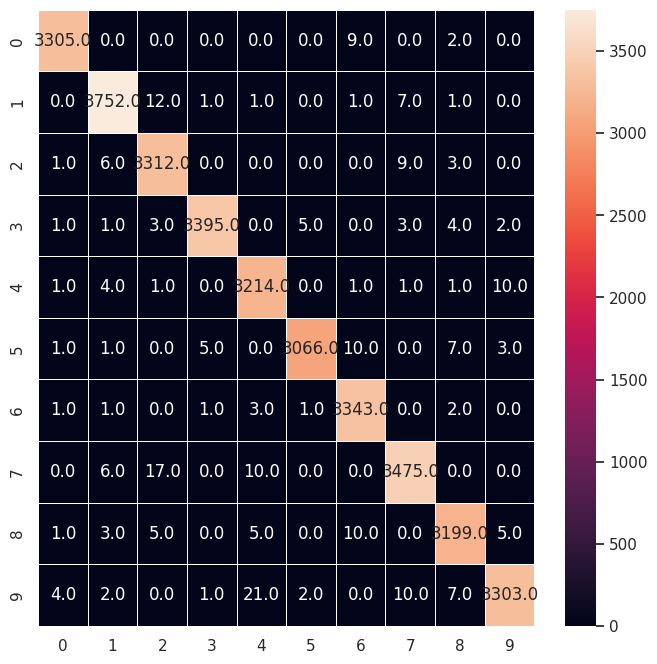

In [37]:
cm_test= confusion_matrix(test_label_np,predicted_test)
plt.figure(figsize=(8,8))
sns.heatmap(cm_train, annot=True, fmt=".1f", linewidth=.5)

In [38]:
y_val.shape

(8400, 10)

In [39]:
y_true = np.argmax(y_val,axis=1)
y_true.shape

(8400,)

In [40]:
errors = predicted_test != y_true
X_val_errors = X_val[errors]
Y_pred_classes_errors = predicted_test[errors]
Y_true_errors = y_val[errors]

In [41]:
X_val_errors.shape


(77, 28, 28, 1)

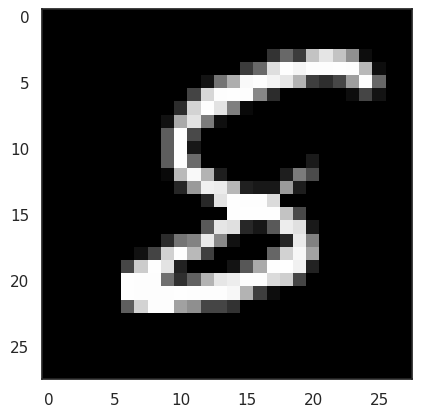

In [42]:
plt.imshow(X_val_errors[0],cmap='gray')

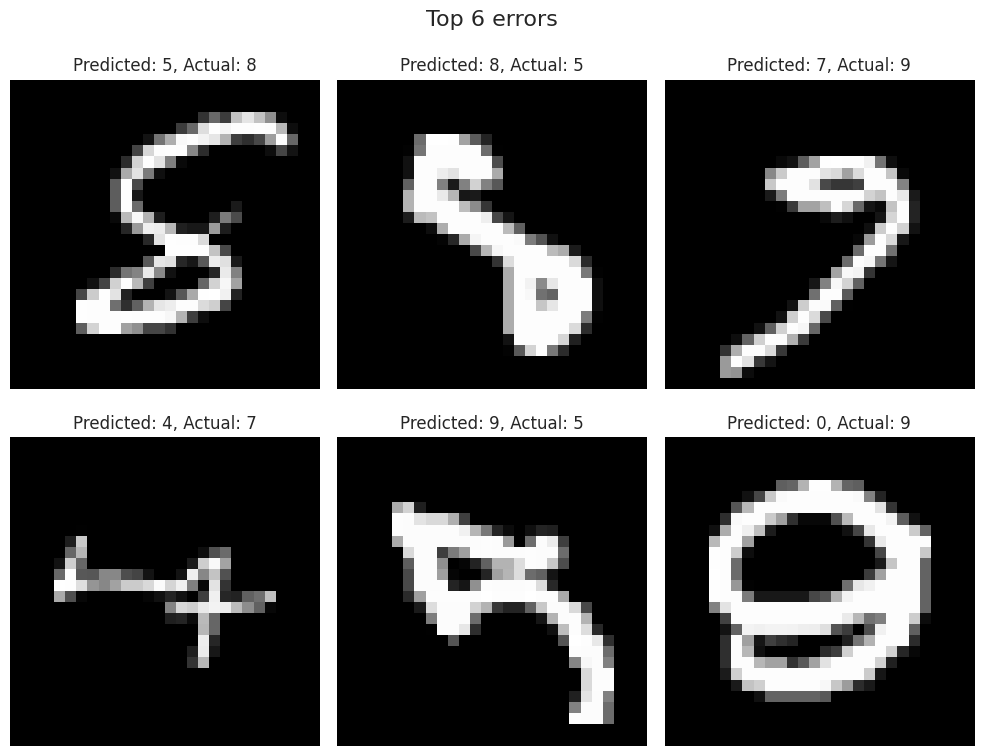

In [43]:
errors = predicted_test != y_true
X_val_errors = X_val[errors]
Y_pred_classes_errors = predicted_test[errors]
Y_true_errors = y_true[errors]

num_errors = len(X_val_errors)
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))
fig.suptitle(f"Top {num_rows * num_cols} errors", fontsize=16)

for i, ax in enumerate(axes.flatten()):
    if i >= num_errors:
        break
    ax.imshow(X_val_errors[i], cmap='gray')
    ax.set_title(f"Predicted: {Y_pred_classes_errors[i]}, Actual: {Y_true_errors[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [44]:
results = model.predict(test_df)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 [==============================] - 2s 2ms/step


In [45]:
test_df.shape

(28000, 28, 28, 1)

In [46]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

# Thanks